# README

This is a set of Python codes (mainly relying on Matplotlib and Pandas) to derive certain summary statistics and plots surrounding submissions, the review process, and website impact. An [API to crossref](https://github.com/fabiobatalha/crossrefapi) is also needed to download the final publication dates which don't seem to be contained in the OJS csv files.
The necessary files can be downloaded from the OJS dashboard with Journal Manager permissions, using the 'Reports' button on the left. The following files are needed:
* Articles Report
* Review Report
* Generate Custom Report (for the website/abstract/pdf stats). The codes below are set-up to aggregate by day, and you will need to select an appropriate time range.

# Install required modules

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from crossref.restful import Works  # CrossRef API
from matplotlib.ticker import MaxNLocator
import matplotlib
import datetime
import matplotlib.font_manager as font_manager

# Add Seismica font and colours styles as default

In [12]:
font_dir = ['/Users/sph1r17/Downloads/Source_Sans_Pro']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
matplotlib.rc('font', family='Source Sans Pro') 
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["#65c18c", "de3c4b", "#123467", "#cecd24", "magenta"]) 

In [259]:
df = pd.read_csv("articles-Seismica-20230516.csv", error_bad_lines=False, 
                 skiprows=0)
df['Date submitted dt'] =  pd.to_datetime(df["Date submitted"])
print(len(df))
df = df[df['Title'].notna()]  # Exclude unsubmitted / drafts
print(len(df))

77
69


# Handling editor assignments

## Change assignments for first few articles and for fast reports

In [252]:
df['Family Name (Editor 1)'] = np.where(df['Family Name (Editor 1)'] == "Mark", df['Family Name (Editor 2)'], df['Family Name (Editor 1)'])
df['Family Name (Editor 1)'] = np.where(df['Family Name (Editor 1)'] == "Ragon", df['Family Name (Editor 2)'], df['Family Name (Editor 1)'])
df['Family Name (Editor 1)'] = np.where(df['Family Name (Editor 1)'] == "Funning", df['Family Name (Editor 3)'], df['Family Name (Editor 1)'])
df['Family Name (Editor 1)'] = np.where(df['Family Name (Editor 1)'] == "Thingbaijam", df['Family Name (Editor 2)'], df['Family Name (Editor 1)'])
df['Family Name (Editor 1)'] = np.where(df['Family Name (Editor 1)'] == "Thingbaijam", df['Family Name (Editor 3)'], df['Family Name (Editor 1)'])

df["Full Name"] = df['Family Name (Editor 1)'].str.upper()

df_not_fast = df[df["Section title"] != "Fast Reports"]

## Plot HEs

Text(0.5, 1.0, 'Total submissions assigned to each editor (excluding Fast Reports)')

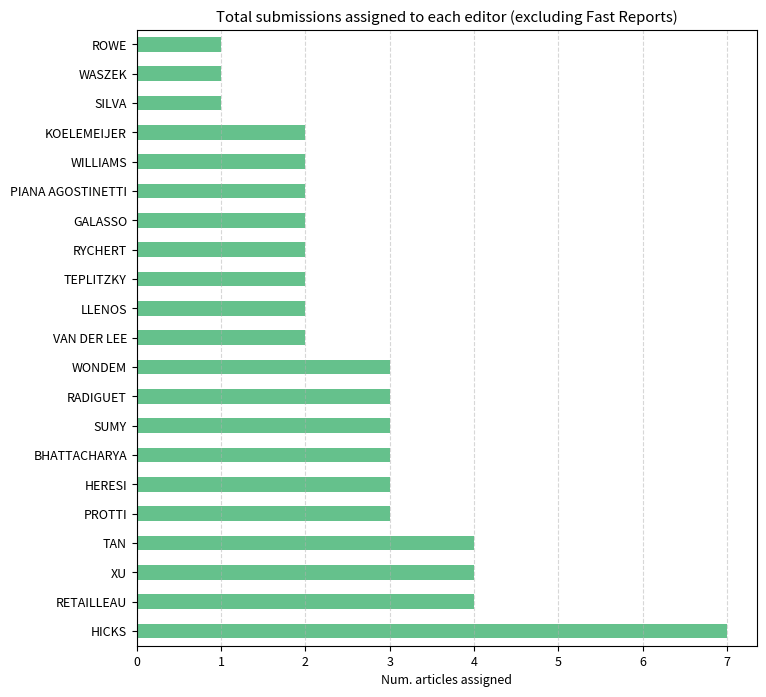

In [253]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
df_not_fast["Full Name"].value_counts().plot(kind='barh', ax=ax)
ax.grid(ls="--", axis="x", alpha=0.5)
ax.set_xlabel("Num. articles assigned")
ax.set_title("Total submissions assigned to each editor (excluding Fast Reports)")

# Submissions vs time

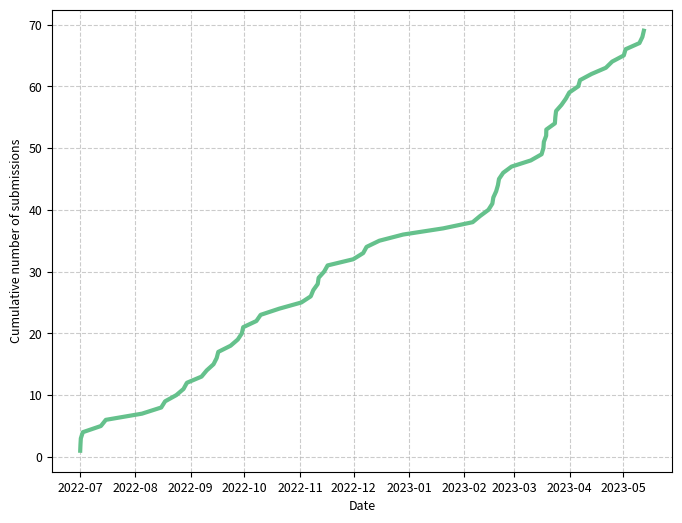

In [296]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
df_sub = df.sort_values(by='Date submitted dt').reset_index()
ax.plot(df_sub['Date submitted dt'], df_sub.index+1, lw=3)
ax.grid(ls="--", alpha=.65)
ax.set_ylabel("Cumulative number of submissions")
ax.set_xlabel("Date")
plt.savefig("subtime.png", dpi=300, bbox_inches="tight", transparent=True)

# Time for submission->publication

## Get final publication date from DOI database and compute number of days

In [258]:
works = Works()

def get_doi_date(x):
    try:
        doi = x["DOI"]
        if str(doi) != "nan":
            print(x["Title"])
            return pd.to_datetime(works.doi(doi)["created"]["date-time"][:-1])
        else:
            return ''
    except:
        return ''

df['published_dt'] = df.apply(lambda x: get_doi_date(x), axis=1)
df['Days to published'] = (df['published_dt'] - df['Date submitted dt']).dt.days
df = df[df['Section title'] != "Editorials"]
df_fast = df[df['Section title'] == "Fast Reports"]
df_pub = df[df["Days to published"].notna()]

Seismic interferometry in the presence of an isolated noise source
Tilt Corrections for Normal Mode Observations on Ocean Bottom Seismic Data, an example from the PI-LAB experiment
The root to the Galápagos mantle plume on the core-mantle boundary 
A Bayesian approach to the tomographic problem with constraints from geodynamic modeling: Application to a synthetic subduction zone
3D Paleoseismology from iOS Lidar and Structure from Motion Photogrammetry: a case study on the Dog Valley fault, California
Ocean Surface Gravity Wave Excitation of Flexural Gravity and Extensional Lamb Waves in Ice Shelves
Source Model and Characteristics of the 27 July 2022 MW 7.0 Northwestern Luzon Earthquake, Philippines
PyRaysum: Software for Modeling Ray-theoretical Plane Body-wave Propagation in Dipping Anisotropic Media
Validation of Peak Ground Velocities Recorded on Very-high rate GNSS Against NGA-West2 Ground Motion Models
Deep learning for denoising High-Rate Global Navigation Satellite System data

## Plot submission -> publication times

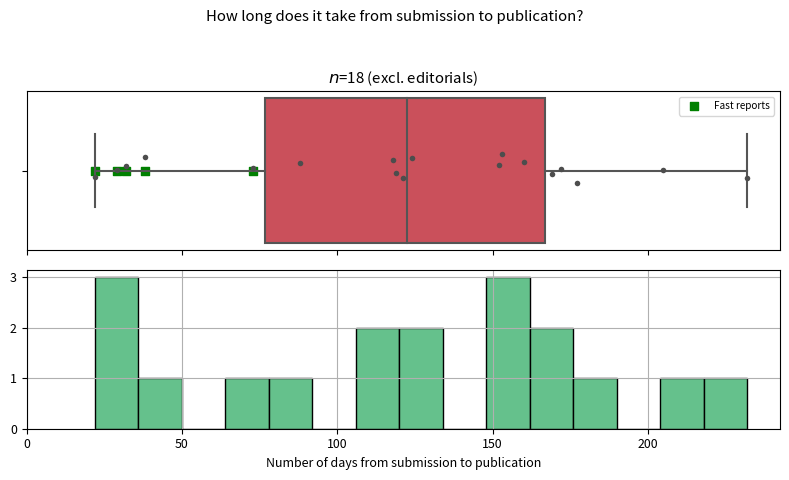

In [97]:
fig1, axs = plt.subplots(2,1, figsize=(8, 5), sharex=True)
ax1 = axs.flatten()[0]

sns.boxplot(ax=ax1, data=df_pub, x=df_pub['Days to published'],
            flierprops={"marker": "x"}, color="#de3c4b")
sns.stripplot(ax=ax1, data=df_pub, x=df_pub['Days to published'],
              size=4, color=".3", linewidth=0)
ax1.set_xlabel("Number of days from submission to publication")
ax1.grid(axis="x")
ax1.set_xlim(0, ax1.get_xlim()[1])
ax1.scatter(df_fast['Days to published'], np.zeros(len(df_fast)),
            label="Fast reports", marker="s", c="green")
nn = len(df_pub)
ax1.set_title(f"$n$={nn} (excl. editorials)")
ax1.legend(fontsize=8)

ax2 = axs.flatten()[1]
ax2.hist(df_pub['Days to published'], ec='k', bins=15, fc="#65c18c")
ax1.grid(axis="x")
ax2.grid()
ax1.set_xlabel("")
ax2.set_xlabel("Number of days from submission to publication")
plt.suptitle("How long does it take from submission to publication?")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# How long does it take from submission until review stage has been initiated?

## Compute

In [292]:
ss = [(i, np.where(df[i] == 'Send to Review')[0].tolist()) for i in list(df)
      if len(np.where(df[i] == 'Send to Review')[0]) > 0]
columns = df.columns
days_to_firstdec = []
for l in ss:
    a = df.columns.get_loc(l[0])+1
    for i in l[1]:
        #print((pd.to_datetime(df.iloc[i, a]) - (df.iloc[i]['Date submitted dt'])).days, df.iloc[i]["Title"], )
        days_to_firstdec.append(
            (pd.to_datetime(df.iloc[i, a]) - (df.iloc[i]['Date submitted dt'])).days) 

3 Short note about detection of a deep Mars mantle seismic discontunity
3 Mechanical Analysis of Fault Slip Rate Sites within the San Gorgonio Pass Region, Southern California USA
0 Apparent Non-Double-Couple Components as Artifacts of Moment Tensor Inversion
4 Exploring the Effect of Minimum Magnitude on California Seismic Hazard Maps
8 Stress on geometrically-rough faults
6 A plea for a comprehensive earthquake education policy in Nepal
21 Spatiotemporal evaluation of Rayleigh surface wave estimated from roadside dark fiber DAS array and traffic noise
20 Investigating global correlations between tsunami, earthquake, and subduction zone characteristics
0 Locating the Nordstream explosions using polarization analysis
1 Contemporary Slip Rates of All Active Faults in the Indo-Asian Collision Zone
7 Seismic Architecture of the Lithosphere-Asthenosphere System in the Western United States from a Joint Inversion of Body- and Surface-wave Observations: Distribution of Partial Melt in the Up

## Plot days to send-to-review

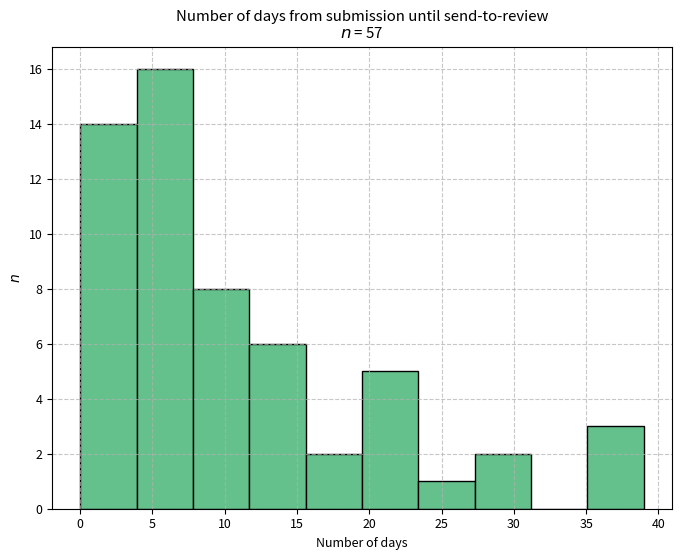

In [293]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(days_to_firstdec, ec="k")
ax.set_ylabel("$n$")
ax.set_xlabel("Number of days")
ax.set_title("Number of days from submission until send-to-review\n$n$ = {}".format(len(days_to_firstdec)))
ax.grid(ls="--", alpha=0.7)

# Get days to first editorial decision after review

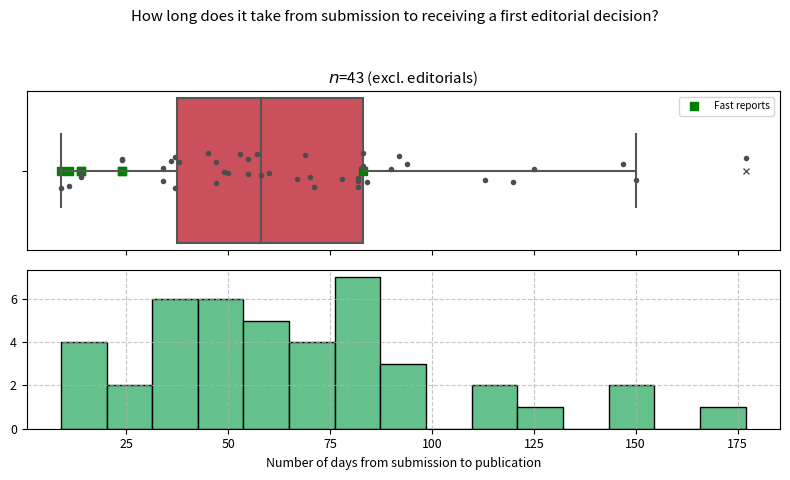

In [101]:
found = False
for idx, r in df.iterrows():
    found = False
    for ndx, (l, c) in enumerate(r.items()):
        if found is False:
            if c == "Request Revisions" or c == "Accept" or c == "Resubmit for Review":
                dec = ndx
                found = True
                break
    if found is True:
        df.loc[idx, 'date_first_dec'] = r[r.index[ndx+1]]
df['date_first_dec dt'] =  pd.to_datetime(df["date_first_dec"])
df['Date submitted dt'] =  pd.to_datetime(df["Date submitted"])
df['Days to first dec'] = (df['date_first_dec dt'] - df['Date submitted dt']).dt.days
df = df[
    (df['Days to first dec'].notna()) &
    (df["Editor Decision 1  (Editor 1)"] != "Decline Submission")
]
df = df[df['Section title'] != "Editorials"]

df_fast = df[(df['Section title'] == "Fast Reports")]



fig1, axs = plt.subplots(2,1, figsize=(8, 5), sharex=True)
ax1 = axs.flatten()[0]

sns.boxplot(ax=ax1, data=df, x=df['Days to first dec'],
            flierprops={"marker": "x"}, color="#de3c4b")
sns.stripplot(ax=ax1, data=df, x=df['Days to first dec'],
              size=4, color=".3", linewidth=0)
ax1.scatter(df_fast['Days to first dec'], np.zeros(len(df_fast)),
            label="Fast reports", marker="s", c="green")
ax1.set_xlabel("Number of days from submission to first editorial decisision")
ax1.grid(axis="x")
ax1.set_xlabel("")

nn = len(df)
ax1.set_title(f"$n$={nn} (excl. editorials)")
ax1.legend(fontsize=8)

ax2 = axs.flatten()[1]
ax2.hist(df['Days to first dec'], ec='k', bins=15)
ax1.grid(axis="x")
ax2.grid(ls="--", alpha=0.7)
ax1.set_xlabel("")
ax2.set_xlabel("Number of days from submission to publication")
plt.suptitle("How long does it take from submission to receiving a first editorial decision?")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Submission Status

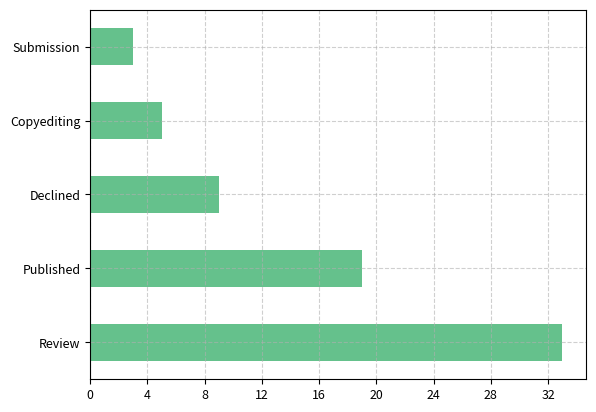

In [110]:
ax = plt.subplot()
df.Status.value_counts().plot.barh(ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(ls="--", alpha=0.6)

# Submission status by article type

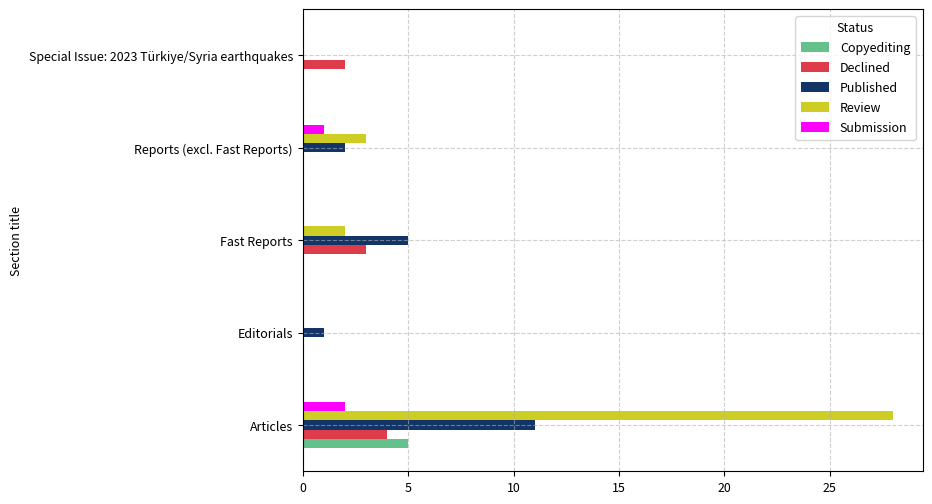

In [111]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()

dfu = df.groupby(['Section title']).Status.value_counts().unstack()


# plot
dfu.plot(kind='barh', ax=ax)
ax.grid(ls="--", alpha=0.6)

# Get Reviewing stats from file

In [114]:
df_rev = pd.read_csv("reviews-20230516.csv")

# Time to decline

In [115]:
df_rev['Date Notified'] = pd.to_datetime(df_rev["Date Notified"])
df_rev['Date Completed'] = pd.to_datetime(df_rev["Date Completed"])
df_rev['date_conf'] = pd.to_datetime(df_rev["Date Confirmed"])

df_rev["days_to_complete"] = (df_rev['Date Completed'] - df_rev['date_conf']).dt.total_seconds() / 86400

df_rev_decl = df_rev[df_rev["Declined"] == "Yes"]
df_rev_decl["days_to_decline"] = (df_rev['date_conf'] - df_rev['Date Notified']).dt.total_seconds() / 86400

# How many reviewers are being thanked / acknowledged

In [301]:
df_rev_submitted = df_rev[df_rev['Date Completed'].notna()]
df_rev_thanks = df_rev_submitted[df_rev_submitted['Date Acknowledged'].notna()]
nreviewssub = len(df_rev_submitted)
nreviews_thanked = len(df_rev_thanks)
print(f"We are currently thanking {100*nreviews_thanked/nreviewssub:.0f}% of reviewers")

We are currently thanking 46% of reviewers


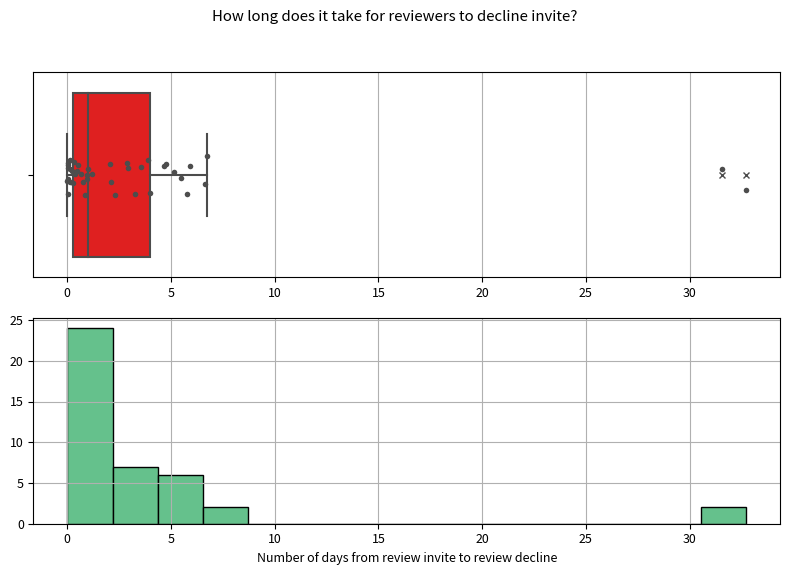

In [117]:
fig1, axs = plt.subplots(2,1, figsize=(8, 6))
ax1 = axs.flatten()[0]
sns.boxplot(ax=ax1, data=df_rev_decl, x=df_rev_decl['days_to_decline'],
            flierprops={"marker": "x"}, color="red")
sns.stripplot(ax=ax1, data=df_rev_decl, x=df_rev_decl['days_to_decline'],
              size=4, color=".3", linewidth=0)
ax2 = axs.flatten()[1]
ax2.hist(df_rev_decl['days_to_decline'], ec='k', bins=15)
ax1.grid(axis="x")
ax2.grid()
ax1.set_xlabel("")
ax2.set_xlabel("Number of days from review invite to review decline")
plt.suptitle("How long does it take for reviewers to decline invite?")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Time to complete review

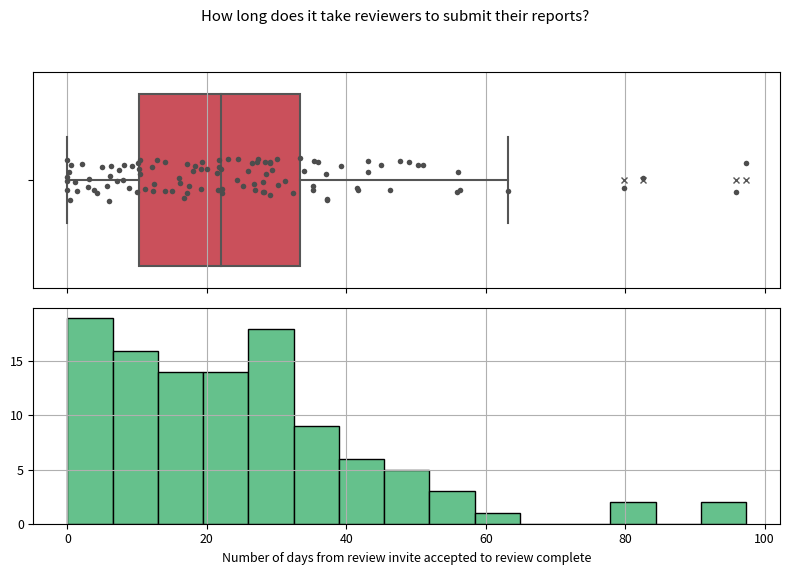

In [120]:
fig1, axs = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax1 = axs.flatten()[0]
sns.boxplot(ax=ax1, data=df_rev, x=df_rev['days_to_complete'],
            flierprops={"marker": "x"}, color="#de3c4b")
sns.stripplot(ax=ax1, data=df_rev, x=df_rev['days_to_complete'],
              size=4, color=".3", linewidth=0)
ax2 = axs.flatten()[1]
ax2.hist(df_rev['days_to_complete'], ec='k', bins=15)
ax1.grid(axis="x")
ax2.grid()
ax1.set_xlabel("")
ax2.set_xlabel("Number of days from review invite accepted to review complete")
plt.suptitle("How long does it take reviewers to submit their reports?")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

df_rev_outliers = df_rev[df_rev["days_to_complete"] > 50]


#all_rev = pd.merge(df, df_rev_outliers, on="Submission ID")
#
#a = all_rev[["days_to_complete", "Family Name (Author 1)", "Title", "Full Name", "Family Name"]]
#a["days_to_complete"] = a["days_to_complete"].astype(int)
#a.rename({"days_to_complete": "No. days to complete review",
#          "Title": "Submission Title",
#          "Full Name": "Handling Editor",
#          "Family Name": "Reviewer"}, axis=1, inplace=True)

#a = df[df["Submission ID"].isin(IDs)][["Title", "Full Name"]]
#a["days_to_complete"] = list(days)
#a["Reviewer name"] = list(reviewer)

#display(HTML(a.sort_values("No. days to complete review").to_html()))

# Review invite acceptance rate

In [302]:
df_rev_nodup = df_rev.drop_duplicates(['Submission ID', 'Reviewer'])
df_rev_sub_count_acc = df_rev_nodup.groupby(
    'Submission ID')['Date Completed'].apply(lambda x: (pd.notnull(x)).sum()).reset_index(name='Reviewers accepted')
df_rev_sub_count_noresp = df_rev_nodup.groupby(
    'Submission ID')['Date Completed'].apply(lambda x: (pd.isnull(x)).sum()).reset_index(name='Reviewers not responded')

In [303]:
all_rev = pd.merge(df_rev_sub_count_acc, df_rev_sub_count_noresp, on="Submission ID")
all_rev["frac"] = all_rev["Reviewers accepted"] / (all_rev["Reviewers accepted"] + all_rev["Reviewers not responded"])

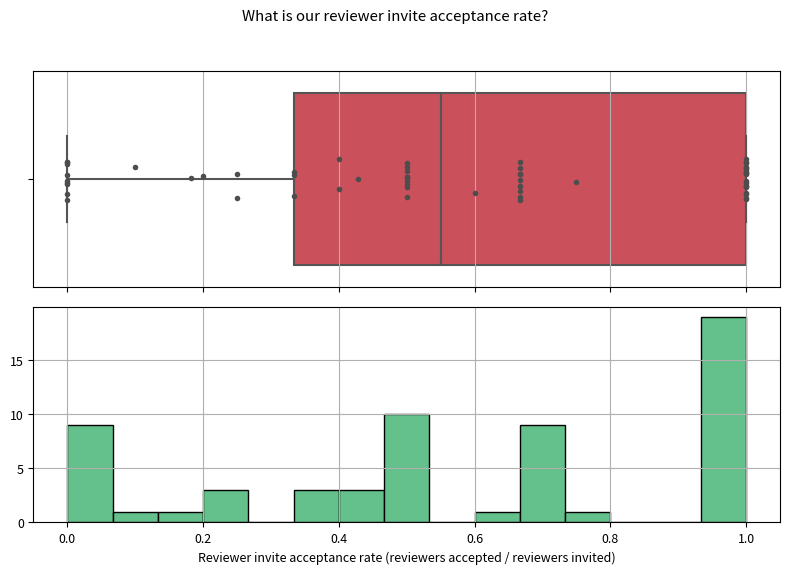

In [125]:
fig1, axs = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax1 = axs.flatten()[0]
sns.boxplot(ax=ax1, data=all_rev, x=all_rev['frac'],
            flierprops={"marker": "x"}, color="#de3c4b")
sns.stripplot(ax=ax1, data=all_rev, x=all_rev['frac'],
              size=4, color=".3", linewidth=0)
ax2 = axs.flatten()[1]
ax2.hist(all_rev['frac'], ec='k', bins=15)
ax1.grid(axis="x")
ax2.grid()
ax1.set_xlabel("")
ax2.set_xlabel("Reviewer invite acceptance rate (reviewers accepted / reviewers invited)")

plt.suptitle("What is our reviewer invite acceptance rate?")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

df_rev_outliers = df_rev[df_rev["days_to_complete"] > 50]


#all_rev = pd.merge(df, df_rev_outliers, on="Submission ID")

#a = all_rev[["days_to_complete", "Family Name (Author 1)", "Title", "Full Name", "Family Name"]]
#a["days_to_complete"] = a["days_to_complete"].astype(int)
#a.rename({"days_to_complete": "No. days to complete review",
#          "Title": "Submission Title",
#          "Full Name": "Handling Editor",
#          "Family Name": "Reviewer"}, axis=1, inplace=True)

#a = df[df["Submission ID"].isin(IDs)][["Title", "Full Name"]]
#a["days_to_complete"] = list(days)
#a["Reviewer name"] = list(reviewer)

#display(HTML(a.sort_values("No. days to complete review").to_html()))

# Website stats

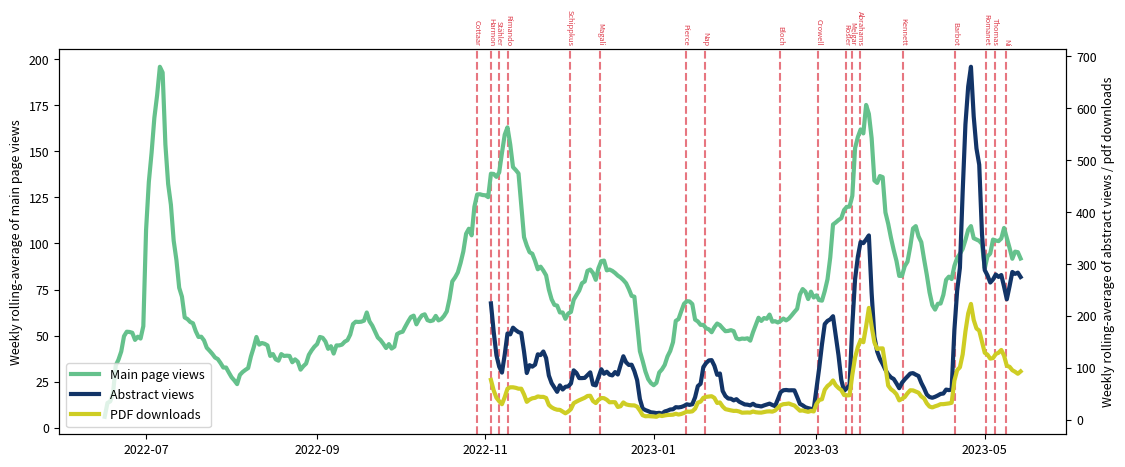

In [295]:
df_mainpage_views = pd.read_csv("statistics-20230516-8.csv", skiprows=5)
df_mainpage_views.index = pd.to_datetime(df_mainpage_views['Day'], format='%Y%m%d')

df_abs_views = pd.read_csv("statistics-20230516-9.csv", skiprows=5)
df_abs_views["dt"] = pd.to_datetime(df_abs_views['Day'], format='%Y%m%d')
df_sum_abs = df_abs_views.groupby("dt")["Count"].sum().rolling(7).mean()

df_pdf_views = pd.read_csv("statistics-20230516-10.csv", skiprows=5)
df_pdf_views["dt"] = pd.to_datetime(df_pdf_views['Day'], format='%Y%m%d')
df_sum_pdf = df_pdf_views.groupby("dt")["Count"].sum().rolling(7).mean()

fig = plt.figure(figsize=(13, 5))
ax = plt.subplot()

ax.plot(df_mainpage_views.index, df_mainpage_views.Count.rolling('7d', min_periods=1).mean(), lw=3, zorder=10,
        label="Main page views")
ax.set_ylabel("Weekly rolling-average of main page views")
for idx, r in df_pub.iterrows():
    ax.axvline(r.published_dt, ls="--", c="#de3c4b", alpha=0.7)
    ax.text(r.published_dt, ax.get_ylim()[1]+2, r["Family Name (Author 1)"], clip_on=False, rotation=-90, ha="center", va="bottom",
            fontsize=6, c="#de3c4b")

ax2 = ax.twinx()
ax2.plot(df_sum_abs, c="#123467", label="Abstract views", lw=3) #"#65c18c", "de3c4b", "#123467", "#cecd24", "magenta)
ax2.plot(df_sum_pdf, c="#cecd24", label="PDF downloads", lw=3) #"#65c18c", "de3c4b", "#123467", "#cecd24", "magenta)

ax2.set_ylabel("Weekly rolling-average of abstract views / pdf downloads")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=3)
plt.savefig("web.png", dpi=300, bbox_inches="tight", transparent=True)

In [308]:
print("Total views to main website to date: ", df_mainpage_views.Count.cumsum().iloc[-1])
print("Total number of abstract views: ", df_abs_views.groupby("dt")["Count"].sum().cumsum().iloc[-1])
print("Total number of pdf downloads: ", df_pdf_views.groupby("dt")["Count"].sum().cumsum().iloc[-1])

Total views to main website to date:  24845
Total number of abstract views:  24794
Total number of pdf downloads:  10767
